In [1]:
import numpy as np
import jax
import sys
import os
from jax import numpy as jnp
import matplotlib.pyplot as plt
git_root = !git rev-parse --show-toplevel
sys.path.append(git_root[0])
from differential_geometry import diffgeo, vdiffgeo
from general_relativity import gravitational_waves_metric, minkowski_metric
jnp.set_printoptions(precision=2)

## Gravitational waves

The gravitational wave metric has two canonical representations, either in spherical or cartesian coordinates. Out of these, the cartesian representation is more commonly used.

The GW metric in cartesian is
$$g_{\mu\nu}=\begin{pmatrix}
-1 & 0 & 0 & 0 \\
0 & 1 + h_{+}cos(\omega(t-z)) & h_{\times}cos(\omega(t-z)) & 0 \\
0 & h_{\times}cos(\omega(t-z)) & 1-h_{+}cos(\omega(t-z)) & 0 \\
0 & 0 & 0 & 1 \\
\end{pmatrix}.$$

It represents a wave propagating in the $+z$ direction. For simplicity we will assume $h_{+}=h_{\times}=const$. In a realistic scenario this is a damped wave and the amplitude decreases as it propagates.

#### 1. Ring deformations

This is the way gravitational waves affect the spacetime geometry. For visualization purposes it is shown for a ring shape.

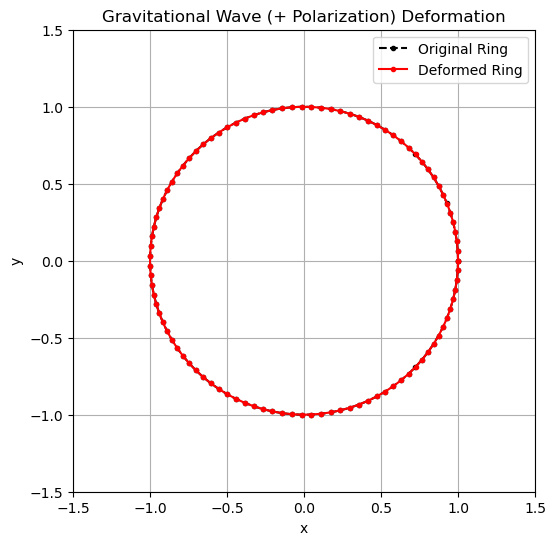

In [9]:
from matplotlib.animation import FuncAnimation

# Gravitational wave parameters
A_plus = 0.1  # Amplitude of + polarization
omega = 1.5  
k = 1.0       
z = 0.0       

# Ring of particles
num_particles = 100
theta = np.linspace(0, 2 * np.pi, num_particles)
radius = 1.0
x0 = radius * np.cos(theta)
y0 = radius * np.sin(theta)

fig, ax = plt.subplots(figsize=(6, 6))
line_original, = ax.plot(x0, y0, 'k--', marker='o',  markersize=3,  label='Original Ring')
line_deformed, = ax.plot([], [], 'r-', marker='o',  markersize=3, label='Deformed Ring')
ax.set_aspect('equal')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_title('Gravitational Wave (+ Polarization) Deformation')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.grid(True)

def update(frame):
    t = frame / 10.0
    phase = omega * t - k * z
    h_plus = A_plus * np.cos(phase)
    x_t = (1.0 + 0.5 * h_plus) * x0
    y_t = (1.0 - 0.5 * h_plus) * y0
    line_deformed.set_data(x_t, y_t)
    return line_deformed,

ani = FuncAnimation(fig, update, frames=200, interval=50, blit=True, repeat=True)
ani.save("gravitational_waves_ring.gif", writer='pillow')

#### 2. Weyl scalar $\Psi_{4}$

Start by defining the metric, lets choose $h_{+}=h_{\times}=10^{-21}$ (realistic amplitudes for LIGO detector) and $\omega=2$

In the NP (Newman-Penrose) formalism, the Weyl scalar is
$$\Psi_{4}=C_{abcd}n^{a}\bar{m}^{b}n^{c}\bar{m}^{d}.
$$

In this expression, $n$ and $m$ correspond to a real and a complex tetrad (four vectors). The bar denotes complex conjugation. They are part of the 4 null-vectors $\{l^{\mu}, n^{\mu}, m^{\mu}, \bar{m}^{\mu}\}$ with the interpretation that $l^{\mu}$ and $n^{\mu}$ are outgoing and ingoing null-vectors which in spherical coordinates it makes sense to think relative to the radial coordinate, but specifically for gravitational waves is relative to the direction of propagation. These null-vectors can be constructed from the tetrad orthonormal basis. It is important to observe these vectors are not orthogonal or even normalized, but are linearly independent.

With an abuse of notation, $h_{+}$ and $h_{\times}$ will corresspond to the components of the metric, not just the amplitude factor, but the cosine dependence as well. For the GW metric like the one above, this scalar reduces to $\Psi_{4}=-\ddot{h}_{+}+i\ddot{h}_{\times}$. Hence, $\Psi_{4}$ incorporates all that we need to know about the wave.

At first sight, you might think why not extracting the wave dependence from the metric. In Numerical Relativity simulations, certain gauge choices in the coordinate system will alter the components of the metric tensor into something that is much harder to take the wave structure. Furthermore, even though $\Psi_{4}$ is a scalar, its not invariant due to the null-vectors. These null-vectors are formed from the tetrads and don't change as 4-vectors. Also, the tetrads null-vectors are not unique. Despite all these comments, people established techniques to make a gauge-invariant version of $\Psi_{4}$. This is not presented here, but its just to motivate why $\Psi_{4}$ scalar is preferred in Numerical Relativity for gravitational waves extraction.

In [5]:
omega = 2.
amplitude = 1e-21
gw_metric = lambda coords: gravitational_waves_metric(coords, (amplitude, amplitude), omega=omega)
gw_metric_geo = diffgeo(gw_metric)

cartesian_coords = jnp.array([3., 4., 5., 2.]) # (t, x, y, z)

l = 1 / jnp.sqrt(2) * jnp.array([1., 1., 0., 0.])
n = 1 / jnp.sqrt(2) * jnp.array([1., 0., 0., -1.])
m = 1 / jnp.sqrt(2) * jnp.array([0., 1., 1j, 0.])

h_plus_ddot = -amplitude * omega**2 * jnp.cos(omega * (cartesian_coords[0] - cartesian_coords[3]))

weyl_scalar = jnp.einsum('ijkl, i, j, k, l ->', gw_metric_geo.weyl_curvature_tensor(cartesian_coords), n, m.conj(), n, m.conj())
# jnp.set_printoptions(precision=2, formatter={'complex_kind': '{:0.2e}'.format})
print(f"Cartesian coordinates: {cartesian_coords}")
print(f"Weyl scalar by AD: {jnp.array([weyl_scalar])}")
print(f"Analytical Weyl scalar: {jnp.array([-h_plus_ddot + 1j * h_plus_ddot])}")

Cartesian coordinates: [3. 4. 5. 2.]
Weyl scalar by AD: [-1.66e-21+1.66e-21j]
Analytical Weyl scalar: [-1.66e-21+1.66e-21j]
